# 1. Import Models and Datasets
I have previously created and exported to "./Data":
    
    - Pandas DataFrame 'df_train' with topic encoded to label[0-10], as raw dataset
    - Pandas Series 'text_train' (with "_" removed), as training documents to be vectorized
    - a count vectorizer fitted to 'text_train'
    - a tf-idf vectorizer fitted to 'text_train'
and to "./Models":

    - a Pipeline object containing ti-idf&logistic regression with 'optimal' parameters
    - a csv file keeping record of models learned so far.

In [1]:
%matplotlib inline
import warnings
from joblib import load, dump
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit, cross_val_score
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a list of english stop words
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs # compute scores for each class
from sklearn.decomposition import TruncatedSVD, PCA


from sklearn.exceptions import ConvergenceWarning

In [2]:
!ls -l Data

total 70840
-rw-r--r--@ 1 shiyunze  staff       629 10 Apr 14:02 Readme.md
-rw-r--r--  1 shiyunze  staff   1685025  9 Apr 17:33 count_vector.joblib
-rw-r--r--  1 shiyunze  staff  15371269  9 Apr 17:33 df_train.joblib
-rw-r--r--  1 shiyunze  staff       761  9 Apr 17:33 label_encoder.joblib
-rw-r--r--  1 shiyunze  staff  14970317  9 Apr 17:33 text_train.joblib
-rw-r--r--  1 shiyunze  staff   2258817  9 Apr 17:33 tf_idf.joblib
-rw-r--r--  1 shiyunze  staff     76218  9 Apr 17:33 y_train.joblib


# 1.1 Import Data

In [3]:
# df_train
with open("Data/df_train.joblib", "rb") as f:
    df_train = load(f)
df_train.head()

# text_train
with open("Data/text_train.joblib", "rb") as f:
    text_train = load(f)
text_train.head()

# y_train
with open("Data/y_train.joblib", "rb") as f:
    y_train = load(f)
y_train

# label_encoder
with open("Data/label_encoder.joblib", "rb") as f:
    label_encoder = load(f)
label_encoder.classes_

# count_vectro
with open("Data/count_vector.joblib", "rb") as f:
    count_vector = load(f)
count_vector

# tf-idf
with open("Data/tf_idf.joblib", "rb") as f:
    tf_idf = load(f)
tf_idf

,article_number,article_words,topic,label
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,4
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,7
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,10
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,4
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,6


0    open,absent,cent,cent,cent,stock,inflow,rate,k...
1    morn,stead,end,end,day,day,day,patch,patch,pat...
2    socc,socc,world,world,recent,law,fifa,fifa,fif...
3    open,forint,forint,forint,forint,cent,cent,ste...
4    morn,complet,weekend,minut,minut,minut,arrow,d...
Name: article_words, dtype: object

array([ 4,  7, 10, ...,  4,  6,  4])

array(['ARTS CULTURE ENTERTAINMENT', 'BIOGRAPHIES PERSONALITIES PEOPLE',
       'DEFENCE', 'DOMESTIC MARKETS', 'FOREX MARKETS', 'HEALTH',
       'IRRELEVANT', 'MONEY MARKETS', 'SCIENCE AND TECHNOLOGY',
       'SHARE LISTINGS', 'SPORTS'], dtype=object)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## 1.2 Import Model

In [4]:
!ls -l Models/

total 2416
-rw-r--r--@ 1 shiyunze  staff      465  9 Apr 12:53 Readme.txt
-rw-r--r--  1 shiyunze  staff  1226773  8 Apr 00:05 best_logi.joblib
-rw-r--r--@ 1 shiyunze  staff       61  9 Apr 12:39 model_collection.csv
-rw-r--r--  1 shiyunze  staff        0 11 Apr 17:35 train_tsvd.joblib


In [5]:
# logistic regressor + tf-idf
with open ("Models/best_logi.joblib", "rb") as file:
    pipe_logi = load(file)
pipe_logi

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
          

## 1.3 Check Scores of the Imported Model on Test Set

In [6]:
df_test = pd.read_csv("test.csv")

text_test = df_test.article_words
y_test = label_encoder.transform(df_test.topic)

print("test set labels and count per class:")
print(np.unique(y_test, return_counts=True)[0])
print(np.unique(y_test, return_counts=True)[1])

# usage of imported pipeline is no difference to imported sklearn class
y_pred = pipe_logi.predict(text_test)
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

test set labels and count per class:
[ 0  1  2  3  4  5  6  7  8  9 10]
[  3  15  13   2  48  14 266  69   3   7  60]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.80      0.53      0.64        15
           2       0.82      0.69      0.75        13
           3       0.50      1.00      0.67         2
           4       0.51      0.62      0.56        48
           5       0.64      0.50      0.56        14
           6       0.92      0.85      0.88       266
           7       0.57      0.62      0.59        69
           8       0.00      0.00      0.00         3
           9       0.56      0.71      0.63         7
          10       0.95      1.00      0.98        60

    accuracy                           0.79       500
   macro avg       0.61      0.69      0.63       500
weighted avg       0.81      0.79      0.79       500



# 2. Pinelining -- Refine the Model with Dimension Reduction
**Pipe 1:**
1. **Count Vector**: min_df = \[1 - 10\]
2. **PCA**: num_components = \[???\]
3. **Logistic Regressor**: 
    - `solver: {newton-cg, sag, saga, lbfgs}`. Algorithm to use in the optimization problem. For multiclass problems, only these 4 algorithms handle multinomial loss.
    - `class_weight: {"balanced", None}, default=None`. "balanced" will adjust weights inversly proportional to class frequencies, i.e penalise large class.
    - `multi_class: {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’`. 
        - `ovr`: one-versus-rest, essentially a binary problem is fit for each label
        - `multinomial`: the loss function is the multinomial loss fit across the entire probability distribution
    - `C: {0.0001 0.001,0.01,0.1,1,10},default=1.0`. Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    - `penalty: {l1, l2}`: Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’, 'saga' and ‘lbfgs’ solvers support only l2 penalties.
    
**Pipe 2:**
1. **TF-IDF**: min_df = \[1 - 10\]
2. same
3. same

## 2.1 PCA first
Before performing grid search on the pipelines, let's perform PCA on our training set and see if we can find most important features.

In [7]:
X_train = count_vector.transform(text_train)
print(repr(X_train))

<9500x35817 sparse matrix of type '<class 'numpy.int64'>'
	with 760415 stored elements in Compressed Sparse Row format>


In [8]:
from scipy import sparse

sparse.issparse(X_train)

True

As shown above, `X_train` is implemented as a `sparse matrix`, [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) is the equivalent of [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) that supports sparse matrices.

### 2.1.1 Scale Features Before Performing SVD.
Before applying PCA, we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the `StandardScaler` module for scaling the features individually. `StandardScaler` subtracts the mean from each features and then scale to unit variance.

z = (x - u) / s

In [9]:
std_scaler = StandardScaler(with_mean=False).fit(X_train)
X_train_std = std_scaler.transform(X_train)
print(repr(X_train_std))

<9500x35817 sparse matrix of type '<class 'numpy.float64'>'
	with 760415 stored elements in Compressed Sparse Row format>


### 2.1.2 Visualize Dataset
Try to plot the classes using the 2 or 3 features with the highest eigenvalue.

In [10]:
svd = TruncatedSVD(n_components=2, random_state=23).fit(X_train_std)
X_train_2d = svd.transform(X_train)
X_train_2d

svd = TruncatedSVD(n_components=3, random_state=23).fit(X_train_std)
X_train_3d = svd.transform(X_train_std)
X_train_3d

array([[0.60508347, 2.1085965 ],
       [0.38813623, 1.43230299],
       [0.38066597, 1.2652294 ],
       ...,
       [0.18586538, 0.35136865],
       [0.47402647, 1.55824846],
       [1.45212365, 5.14971621]])

array([[ 0.92605418,  3.2306325 , -1.52312379],
       [ 0.69346888,  2.56704826, -1.21205097],
       [ 0.94053165,  3.06917416, -1.44236448],
       ...,
       [ 1.07127515,  0.35389279, -0.18616182],
       [ 1.8243825 ,  6.07100349, -2.81667226],
       [ 3.76059088, 13.33245643, -6.08594413]])

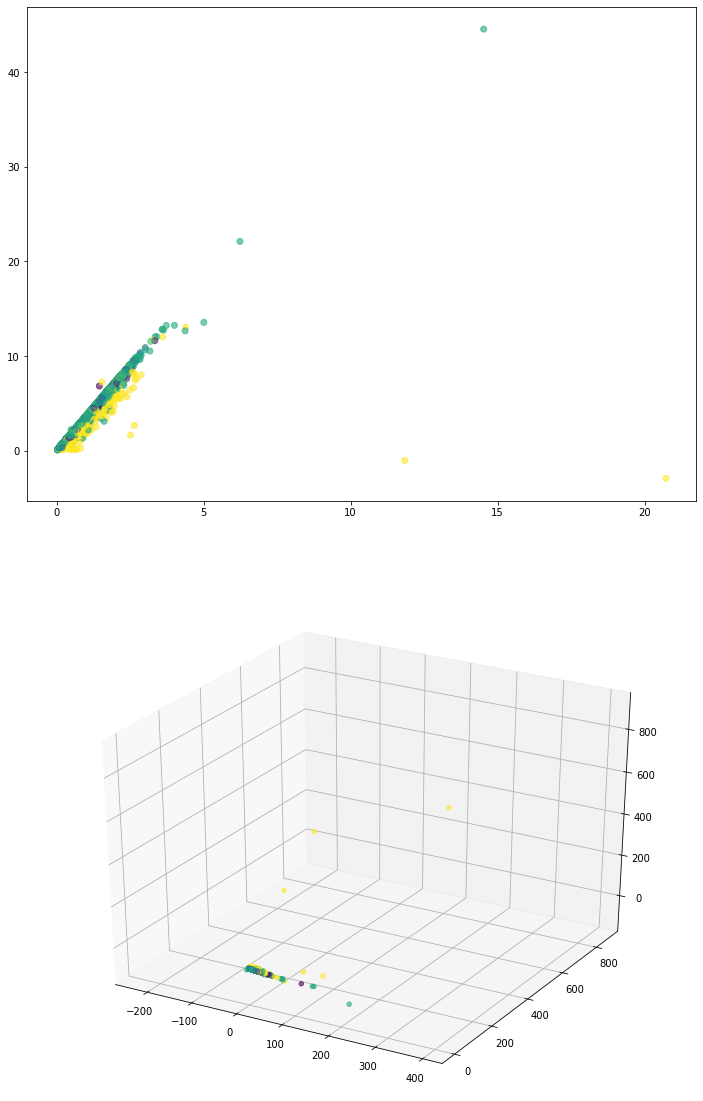

In [11]:
fig = plt.figure(figsize=(12,20))
ax_1 = fig.add_subplot(211)
ax_1.scatter(X_train_2d[:,0], X_train_2d[:,1],c=y_train,alpha=0.6)

ax_2 = fig.add_subplot(212, projection='3d')
ax_2.scatter(X_train_3d[:,1], X_train_3d[:,0],X_train_3d[:,2],c=y_train, alpha=0.6)
plt.show()

**Conclusion**: impossible to observe a distribution of each classes in 2 or 3 dimensional spaces.

### 2.1.2 Visualize the SVD
In order to get a proper n_component for SVD, from reading the documentation, it is suggested that for such a task, 100 is always a good start, here we used a large enough value-5000 and computed corresponding transformer.

Plot the explained variance ratio of the components to find out a proper n_component:

In [12]:
%%time
# compute the singluar decomposition of X_train,strating with a big enough n_component
n = 4000
reduce_dim = TruncatedSVD(n_components=n,random_state=23).fit(X_train_std)

CPU times: user 6min 34s, sys: 18.5 s, total: 6min 52s
Wall time: 4min 14s


In [13]:
reduce_dim

TruncatedSVD(algorithm='randomized', n_components=4000, n_iter=5,
             random_state=23, tol=0.0)

In [14]:
reduce_dim.explained_variance_ratio_.cumsum()

array([0.00301698, 0.00488563, 0.00751697, ..., 0.86728255, 0.86734827,
       0.86741382])

Text(0.5, 0, 'number of principle components')

Text(0, 0.5, 'explained variance ratio')

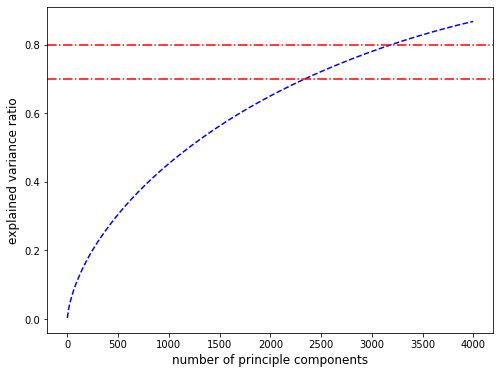

In [15]:
# plot the cumulative sum of eig_sum upto n=3500:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(n), reduce_dim.explained_variance_ratio_.cumsum(),'b--')
ax.set_xlabel("number of principle components", size='large')
ax.set_ylabel("explained variance ratio", size='large')

ax.axhline(y=0.8, ls='-.', c='red')
ax.axhline(y=0.7, ls='-.', c='red')
plt.show()

**Conclusion**: from the pictrure above we can conclude that <font color='red'>3500</font> is probably a proper number of principle components, because the first 3500 features accouts for over 80% of the variance of total components.

In [16]:
%%time
X_train_reduced = reduce_dim.transform(X_train_std)
print(X_train_reduced.shape)

(9500, 4000)
CPU times: user 2.48 s, sys: 501 ms, total: 2.99 s
Wall time: 3.01 s


In [17]:
X_train_std.size
X_train_reduced.size

760415

38000000

### 2.1.3 4000-component training set

In [18]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all
accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train_reduced, y_train,scoring='accuracy', cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.641 ( 0.006)
CPU times: user 1.62 s, sys: 1.03 s, total: 2.65 s
Wall time: 3min 30s


### 2.1.4 2000 components

In [19]:
%%time
X_train_2000 = TruncatedSVD(n_components=2000,random_state=23).fit_transform(X_train_std)

CPU times: user 1min 59s, sys: 7.94 s, total: 2min 7s
Wall time: 1min 22s


In [20]:
X_train_2000.size

19000000

In [21]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all
accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train_2000, y_train,scoring='accuracy', cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.647 ( 0.003)
CPU times: user 1.07 s, sys: 370 ms, total: 1.44 s
Wall time: 54.9 s


## 2.2 TF-IDF with PCA
As is shown above, using PCA to reduce dimension jepordized training accuracy a lot.

Previously we used CountVectorizer to transform the text, let's try tf-idf next.

In [22]:
tfidf = TfidfVectorizer().fit(text_train)
X_train_tfidf = tfidf.transform(text_train)

In [23]:
# Standardize the Matrix
std_scaler = StandardScaler(with_mean=False).fit(X_train_tfidf)
X_train_std = std_scaler.transform(X_train_tfidf)
print(X_train_std.shape, X_train_std.size)

(9500, 35817) 760415


In [24]:
%%time
svd = TruncatedSVD(n_components=4000, random_state=23).fit(X_train_std)

CPU times: user 6min 53s, sys: 21.5 s, total: 7min 15s
Wall time: 4min 39s


In [25]:
X_train_reduced = svd.transform(X_train_std)
print(X_train_reduced.shape, X_train_reduced.size)

(9500, 4000) 38000000


Text(0.5, 0, 'number of principle components')

Text(0, 0.5, 'explained variance ratio')

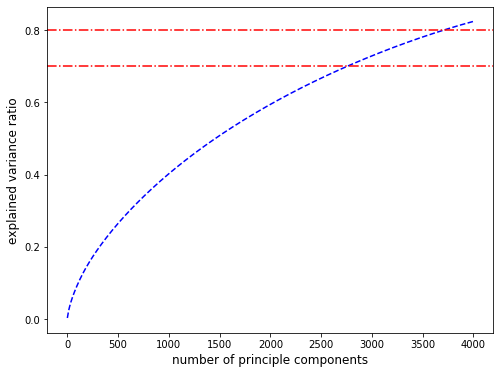

In [26]:
# Plot the cumulative sum of explained variance ratio
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(n), svd.explained_variance_ratio_.cumsum(),'b--')
ax.set_xlabel("number of principle components", size='large')
ax.set_ylabel("explained variance ratio", size='large')

ax.axhline(y=0.8, ls='-.', c='red')
ax.axhline(y=0.7, ls='-.', c='red')
plt.show()

In [27]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all
accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train_reduced, y_train,scoring='accuracy', cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.611 ( 0.009)
CPU times: user 1.65 s, sys: 1.06 s, total: 2.71 s
Wall time: 3min 31s


## 2.3 Export the 2 Models
1. count vector + SVD(4000)
2. tf-idf + SVD(4000)
Both without any tuning:

In [ ]:
# with open("Models/tsvd_countvector.joblib", "wb") as file:
#     dump()

# 3. Tune the model
Find an optimal `min_df`, `ngram_range` value of `tfidf`

In [68]:
%%time
estimators = [
    ("tfidf", TfidfVectorizer(min_df=5)),
    ("LR", LogisticRegression(class_weight='balanced',multi_class='ovr',n_jobs=-1))
]

pipe = Pipeline(estimators)

param_grid = {
    "tfidf__min_df": np.arange(1,10),
    "tfidf__ngram_range": [(1,2)],
    "LR__C":[0.001, 0.01, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)

CPU times: user 7.95 s, sys: 3.51 s, total: 11.5 s
Wall time: 26min 25s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                                        n

In [69]:
grid.best_score_
grid.best_params_

0.7812631578947369

{'LR__C': 10, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}

In [70]:
grid.cv_results_

{'mean_fit_time': array([ 18.41176653,  10.10097351,   8.93056736,   8.44149361,
          7.66548319,   6.94561334,   6.42976298,   6.17397513,
          6.8419704 ,  28.4797822 ,  14.73711042,   9.38993745,
          8.3529429 ,   8.51160765,   7.73418536,   7.31440339,
          6.7821702 ,   6.63498836,  84.3972436 ,  31.44960456,
         19.63113503,  13.94635425,  12.42631545,  11.72837105,
         11.27978344,  10.54872999,  10.17589264, 140.91905093,
         65.11829724,  34.89248266,  25.26536222,  22.40616183,
         19.14269886,  18.12148705,  16.05007148,  14.92130466,
        182.67493477,  77.26477771,  40.16991224,  28.37231393,
         28.61644144,  24.64096265,  21.2932147 ,  20.49350858,
         17.74630718]),
 'std_fit_time': array([ 1.98564688,  0.2426557 ,  0.48218089,  0.22735624,  0.32423785,
         0.20902126,  0.31627944,  0.10267593,  1.32233586,  3.46809512,
         1.57697617,  0.64689961,  0.45837144,  0.29520318,  0.35061903,
         0.20267484,

In [71]:
y_pred = grid.predict(text_test)
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.67      0.44         3
           1       0.86      0.40      0.55        15
           2       0.83      0.77      0.80        13
           3       0.40      1.00      0.57         2
           4       0.42      0.42      0.42        48
           5       0.64      0.64      0.64        14
           6       0.91      0.86      0.88       266
           7       0.49      0.59      0.54        69
           8       0.00      0.00      0.00         3
           9       0.50      0.43      0.46         7
          10       0.95      0.98      0.97        60

    accuracy                           0.76       500
   macro avg       0.58      0.61      0.57       500
weighted avg       0.78      0.76      0.77       500



# 4 Conclusion
1. So far, the exported best_logi is the best model.
2. PCA don not help with the prediction.